# Introduction

This notebook is dedicated to calculating and predicting the credit approval from several features and using "Status" column as the target variable (or 'y'). Status has several data as category, that was:
- 0, C and X = Very Good (No Loan Problem)
- 1 = Good
- 2 - 3 = Not Bad
- 4 = Bad
- 5 = Very Bad

To achieve this, we will deep learning framework that was Feedforward Neural Network that was used by some paramaters:
- **Activation:** Softmax (because of the output was multiple class)
- **Loss:** Categorical crossentropy (use it because there are more than two possible classes. Each sample belongs to exactly one of these classes)
- **Metrics:** Accuracy (using accuracy of diffrences TP, TN, FN, FT)

This notebook is for not using SMOTE as resampling dataset, and find the which one is good. Using the deep learning models, the workflow will follow these steps:
- **Load Data:** Import the dataset and perform initial data inspection to understand its structure and contents.
- **Data Preprocessing:** Clean the data by handling missing values, encoding categorical variables, and normalizing numerical features where necessary.
- **PCA:** To reduce dimensions of data features with good number of dimension.
- **Train-Test Split:** Divide the dataset into training and testing sets to evaluate model performance.
- **Model Training:** Train the CatBoost and Random Forest models using the training data.
- **Model Evaluation:** Assess the performance of the trained models using various metrics.
- **Model Tuning:** Optimize model hyperparameters to improve accuracy and other performance metrics.
- **Final Evaluation:** Conduct a final evaluation of the tuned models on the test data.

For evaluating the performance of the models, the following metrics will be used:
- **Accuracy:** The proportion of correctly classified instances out of the total instances.
- **F1 Score:** The harmonic mean of precision and recall, which provides a balance between the two.
- **Recall Score:** The ability of the model to correctly identify all relevant instances (i.e., correctly predicting cancellations).

In [1]:
#!nvcc -V && which nvcc

In [2]:
#!python --version
#!nvidia-smi

# Importing Libraries

In [3]:
# importing libraries fundamentals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
import datetime
from matplotlib import pyplot

# Library for Null Values Imputing
import missingno as msno

# Library for Encoding and Imputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# for multiclass data dealt with it
from imblearn.over_sampling import SMOTE

# Library for Deep Learning Frameworks
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# importing cudas

2024-07-27 07:52:32.231825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 07:52:32.231927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 07:52:32.359419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the Dataset

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit_record.csv
/kaggle/input/application_record.csv


In [5]:
# load cudas extension

# %load_ext cudf.pandas

df = pd.read_csv('/kaggle/input/application_record.csv')
df2 = pd.read_csv('/kaggle/input/credit_record.csv')

## Dataset Information

In [6]:
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [7]:
df2.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [8]:
print(df.shape)
print(df2.shape)

(438557, 18)
(1048575, 3)


In [9]:
print(f"Comparison rows of df 1 and df 2 id {438557/1048575 * 100} %")

Comparison rows of df 1 and df 2 id 41.824094604582406 %


In [10]:
df.describe()
# description of dataset

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [11]:
df.describe(include='object').T

,count,unique,top,freq
CODE_GENDER,438557,2,F,294440
FLAG_OWN_CAR,438557,2,N,275459
FLAG_OWN_REALTY,438557,2,Y,304074
NAME_INCOME_TYPE,438557,5,Working,226104
NAME_EDUCATION_TYPE,438557,5,Secondary / secondary special,301821
NAME_FAMILY_STATUS,438557,5,Married,299828
NAME_HOUSING_TYPE,438557,6,House / apartment,393831
OCCUPATION_TYPE,304354,18,Laborers,78240


In [12]:
df.info(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

(None, None)

In [13]:
df.shape

(438557, 18)

## Find the Categorical and Numerical dtype

### dataframe 1

In [14]:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')


In [15]:
for col in object_columns:
    d_type = df[col].dtype

    counts =df[col].value_counts()
    print(f"Counts for {col}:")
    print(counts)
    print("============================================================")

Counts for CODE_GENDER:
CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64
Counts for FLAG_OWN_CAR:
FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64
Counts for FLAG_OWN_REALTY:
FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64
Counts for NAME_INCOME_TYPE:
NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64
Counts for NAME_EDUCATION_TYPE:
NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64
Counts for NAME_FAMILY_STATUS:
NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: in

In [16]:
num_columns = df.select_dtypes(include=['float', 'int64']).columns
print(num_columns)

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS'],
      dtype='object')


### dataframe 2

In [17]:
object_columns2 = df2.select_dtypes(include=['object']).columns
print(object_columns2)

Index(['STATUS'], dtype='object')


In [18]:
for col in object_columns2:
    d_type = df2[col].dtype

    counts =df2[col].value_counts()
    print(f"Counts for {col}:")
    print(counts)
    print("============================================================")

Counts for STATUS:
STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64


In [19]:
num_columns2 = df2.select_dtypes(include=['float', 'int64']).columns
print(num_columns2)

Index(['ID', 'MONTHS_BALANCE'], dtype='object')


## Dealt with Null Values



In [20]:
df.isnull().sum(),

(ID                          0
 CODE_GENDER                 0
 FLAG_OWN_CAR                0
 FLAG_OWN_REALTY             0
 CNT_CHILDREN                0
 AMT_INCOME_TOTAL            0
 NAME_INCOME_TYPE            0
 NAME_EDUCATION_TYPE         0
 NAME_FAMILY_STATUS          0
 NAME_HOUSING_TYPE           0
 DAYS_BIRTH                  0
 DAYS_EMPLOYED               0
 FLAG_MOBIL                  0
 FLAG_WORK_PHONE             0
 FLAG_PHONE                  0
 FLAG_EMAIL                  0
 OCCUPATION_TYPE        134203
 CNT_FAM_MEMBERS             0
 dtype: int64,)

In [21]:
df2.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [22]:
def fill_categorical(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

df = fill_categorical(df)

/tmp/ipykernel_34/635066549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [23]:
def fill_categorical(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

df = fill_categorical(df)

/tmp/ipykernel_34/635066549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [24]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Empty DataFrame


theres no null value again :)

## Dealt with Duplicated Value

In [25]:
df['ID'].duplicated().sum()

47

In [26]:
df = df.drop_duplicates(subset='ID',keep='first')

In [27]:
df['ID'].duplicated().sum()

0

# Feature Engineering 

## Classifying Status for Good Interpretation

from original dataset, the int in "STATUS", stands for:
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month

Then i classification again dataset for good interpretation. Credit Classes that i classified:

- 0, C and X = Very Good (No Loan Problem)
- 1 = Good
- 2 - 3 = Not Bad
- 4 = Bad
- 5 = Very Bad

In [28]:
df2['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [29]:
def classify_client(status):
    if status in ['C', 'X', '0']:
        return 'Very Good'
    
    elif status in ['1']:
        return 'Good'
    
    elif status in ['2', '3']: 
        return 'Not Bad'
    
    elif status in ['4']:
        return 'Bad'
    
    elif status in ['5']:
        return 'Very Bad'
    
    else:
        return 'Unknown'

    
df2['STATUS'] = df2['STATUS'].apply(classify_client)
print(df2['STATUS'].value_counts())

STATUS
Very Good    1034381
Good           11090
Very Bad        1693
Not Bad         1188
Bad              223
Name: count, dtype: int64


In [30]:
# Retrieve Data to 'int' again and Rank the Classes into'int'

def retrieve_data(status):
    if status in ['Very Good']:
        return 1
    
    elif status in ['Good']:
        return 2
    
    elif status in ['Not Bad']:  # corrected this line
        return 3
    
    elif status in ['Bad']:
        return 4
    
    elif status in ['Very Bad']: 
        return 5
    
    else:
        return 0

df2['STATUS'] = df2['STATUS'].apply(retrieve_data)
print(df2['STATUS'].value_counts())

STATUS
1    1034381
2      11090
5       1693
3       1188
4        223
Name: count, dtype: int64


In [31]:
# Group by ID and create separate DataFrames for STATUS and MONTHS_BALANCE

credit_status = df2.groupby('ID')['STATUS'].agg("max").reset_index()
months_balance = df2.groupby('ID')['MONTHS_BALANCE'].agg("max").reset_index()

# Merging the dataframes

df = pd.merge(df, credit_status, how='inner', on='ID')
df = pd.merge(df, months_balance, how='inner', on='ID')

In [32]:
df = df.sort_values('AMT_INCOME_TOTAL')
df = df.reset_index(drop=True)
df.ID=df.index
df.columns = ('User_id',
              'Gender',
              'Car',
              'Realty',
              'children_count',
              'income_amount',
              'income_type',
              'education_type',
              'Family_status',
              'Housing_type',
              'Days_birth',
              'Days_employed',
              'Mobile',
              'Work_phone',
              'Phone',
              'Email',
              'Occupation_type',
              'Count_family_members',
              'Status',
              'Month_Balance'
              )

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   User_id               36457 non-null  int64  
 1   Gender                36457 non-null  object 
 2   Car                   36457 non-null  object 
 3   Realty                36457 non-null  object 
 4   children_count        36457 non-null  int64  
 5   income_amount         36457 non-null  float64
 6   income_type           36457 non-null  object 
 7   education_type        36457 non-null  object 
 8   Family_status         36457 non-null  object 
 9   Housing_type          36457 non-null  object 
 10  Days_birth            36457 non-null  int64  
 11  Days_employed         36457 non-null  int64  
 12  Mobile                36457 non-null  int64  
 13  Work_phone            36457 non-null  int64  
 14  Phone                 36457 non-null  int64  
 15  Email              

## Drop some useless features

In [34]:
df = df.drop(["Days_birth", "Mobile", "Phone", "Work_phone", "Email", 
               "Count_family_members", "children_count", "Gender", 'User_id'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Car              36457 non-null  object 
 1   Realty           36457 non-null  object 
 2   income_amount    36457 non-null  float64
 3   income_type      36457 non-null  object 
 4   education_type   36457 non-null  object 
 5   Family_status    36457 non-null  object 
 6   Housing_type     36457 non-null  object 
 7   Days_employed    36457 non-null  int64  
 8   Occupation_type  36457 non-null  object 
 9   Status           36457 non-null  int64  
 10  Month_Balance    36457 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 3.1+ MB


# Split data, SMOTE and Encoding

In [35]:
X = df.drop(columns=['Status'])
y = df['Status']

In [36]:
# Assuming X and y are already defined
categorical_columns = X.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['Car', 'Realty', 'income_type', 'education_type', 'Family_status',
       'Housing_type', 'Occupation_type'],
      dtype='object')


In [37]:
def one_hot_encode_x(X, categorical_columns):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_array_X = encoder.fit_transform(X[categorical_columns])
    encoded_df_X = pd.DataFrame(encoded_array_X, columns=encoder.get_feature_names_out(categorical_columns))
    X = X.drop(columns=categorical_columns)
    X = pd.concat([X, encoded_df_X], axis=1)

    return X

def one_hot_encode_y(y):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_array_y = encoder.fit_transform(y.values.reshape(-1, 1))
    encoded_df_y = pd.DataFrame(encoded_array_y, columns=["Status_" + str(i) for i in range(encoded_array_y.shape[1])])

    return encoded_df_y

X_encoded = one_hot_encode_x(X, categorical_columns)
y_encoded = one_hot_encode_y(y)

# PCA

i need to use PCA, because of data was so hard for being fit

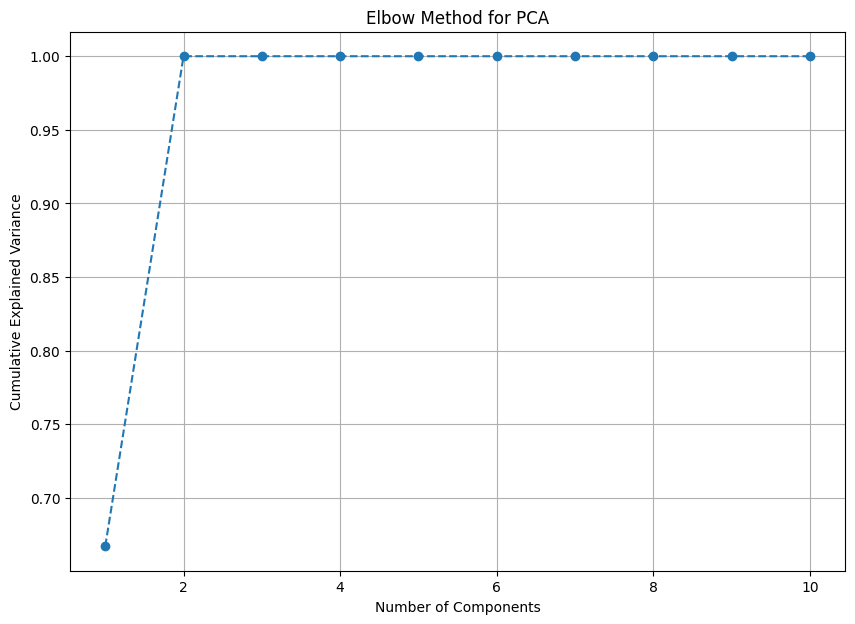

In [38]:
pca = PCA()
pca.fit(X_encoded)

# Calculate explained variance ratio for each number of components
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), explained_variance_ratio[:10], marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

In [39]:
def perform_pca(X_encoded):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_encoded)
    return X_pca

X_pca = perform_pca(X_encoded)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(29165, 2) (29165, 5)
(7292, 2) (7292, 5)


Distribution of Percentage: Status
1    88.229970
2    10.080369
3     1.069753
5     0.493732
4     0.126176
Name: proportion, dtype: float64


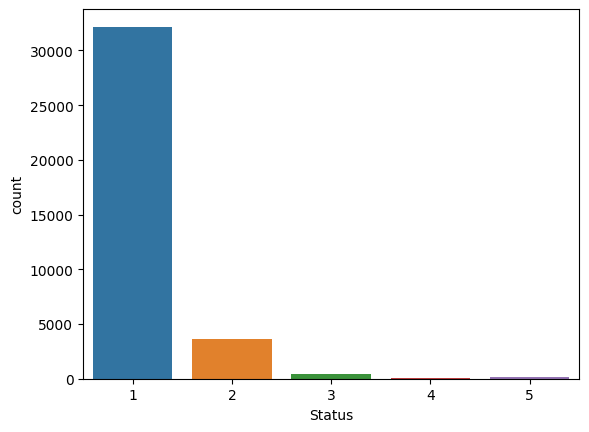

In [41]:
sns.countplot(x='Status', data=df)
print(f"Distribution of Percentage: {df['Status'].value_counts(normalize=True) * 100}")

# Feedforward Neural Network (FNN)

### Build Model

In [42]:
# Learning rate scheduler

def lr_scheduler(epoch, lr):
    decay_rate = 0.96
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

In [43]:
def build_model_fnn():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Output layer
    model.add(Dense(5, activation='softmax')) # softmax output for binary classification dtype
                                              # 5 for all of y output sum
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model_fnn()

In [44]:
# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.3, 
                    epochs=150, 
                    batch_size=32, 
                    callbacks=[early_stopping, lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
 95/638 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2991 - loss: 1.7264

I0000 00:00:1722066777.552729     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


638/638 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6561 - loss: 1.0362 - val_accuracy: 0.8838 - val_loss: 0.4271 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8800 - loss: 0.4550 - val_accuracy: 0.8838 - val_loss: 0.4254 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8829 - loss: 0.4423 - val_accuracy: 0.8840 - val_loss: 0.4246 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/150
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8814 - loss: 0.4442 - val_accuracy: 0.8838 - val_loss: 0.4215 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/150
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8806 - loss:

## Train Loss/Validation Loss (Model Overview)

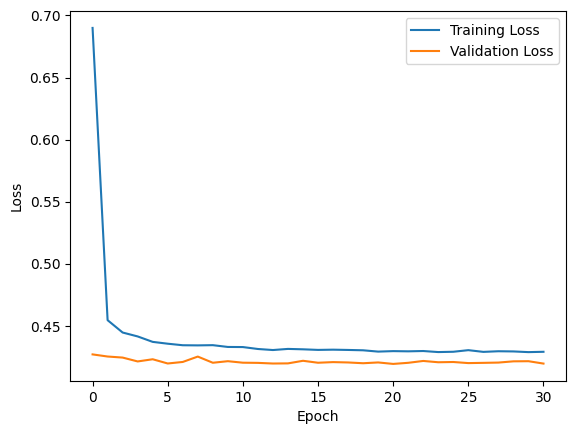

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
y_pred = (model.predict(X_test) > 0.7).astype("int") # Threshold for Data set up for 0.7 from 1.0
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6440
           1       0.00      0.00      0.00       732
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        35

   micro avg       0.88      0.88      0.88      7292
   macro avg       0.18      0.20      0.19      7292
weighted avg       0.78      0.88      0.83      7292
 samples avg       0.88      0.88      0.88      7292

Accuracy on the test set: 0.8830


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the Models

In [47]:
model.save('path/to/model.h5')

# Conclusion

This model might be good for data. This is indicated by decrease train loss and validaton loss, suggesting that the model is not learning effectively from the training data. I think the data wasnt too bad for val loss dont decrease so quickly, but the still good. I use PCA both of FNN models. Futhermore,  we could found the metrics was:
- **Accuracy: 0.88** 

This is looks good for models metrics, but cant 100% sure for predict credit approval. this one needs to study more, because of data so Imbalanced. Distribution of Percentage of Status:
- **1 = 88.22%** 
- **2 = 10.08%** 
- **3 = 1.06%** 
- **5 = 0.49%** 
- **4 = 0.12%** 

I think the best one was using ML Tree Based Models that was being calculated too. Firstly, the data was being resampling by SMOTE and Secondly, the metrics was good too